<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [7]:
#!pip install tensorflow==2.5.0

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

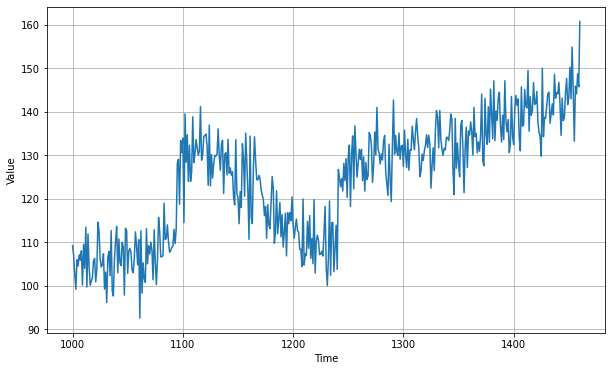

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [11]:
import tensorflow as tf

inputs = tf.random.stateless_uniform(shape=(10, 3), seed=(2, 3))

dataset = tf.data.Dataset.from_tensor_slices(inputs)
dataset = dataset.window(2 + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(2 + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

for x, y in dataset:
  print(x.numpy())
  print(y.numpy())


[[0.17481351 0.9780868  0.21659851]
 [0.06400132 0.09656215 0.47875798]]
[0.25138664 0.6941327  0.04970336]
[[0.06400132 0.09656215 0.47875798]
 [0.25138664 0.6941327  0.04970336]]
[0.4864185  0.36503315 0.55211616]
[[0.25138664 0.6941327  0.04970336]
 [0.4864185  0.36503315 0.55211616]]
[0.13486934 0.60070515 0.72435796]
[[0.4864185  0.36503315 0.55211616]
 [0.13486934 0.60070515 0.72435796]]
[0.7808713  0.09234262 0.15033805]
[[0.13486934 0.60070515 0.72435796]
 [0.7808713  0.09234262 0.15033805]]
[0.3792094  0.70467794 0.88872313]
[[0.7808713  0.09234262 0.15033805]
 [0.3792094  0.70467794 0.88872313]]
[0.7090142  0.42933047 0.7040293 ]
[[0.3792094  0.70467794 0.88872313]
 [0.7090142  0.42933047 0.7040293 ]]
[0.7894927  0.11259401 0.1036483 ]
[[0.7090142  0.42933047 0.7040293 ]
 [0.7894927  0.11259401 0.1036483 ]]
[0.3838899  0.6182116  0.12341106]


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [36]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=0)


,loss
0,503.511566
1,50.208393
2,45.183918
3,45.569763
4,44.805130
...,...
95,35.032497
96,34.834187
97,34.400585
98,34.857712


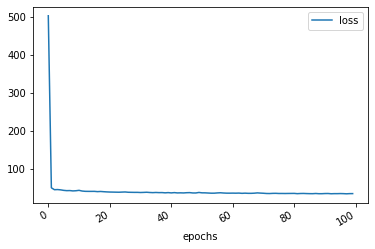

In [38]:
import pandas as pd

metrics = pd.DataFrame(history.history)
metrics.plot(xlabel="epochs", subplots=True, legend=True)
metrics

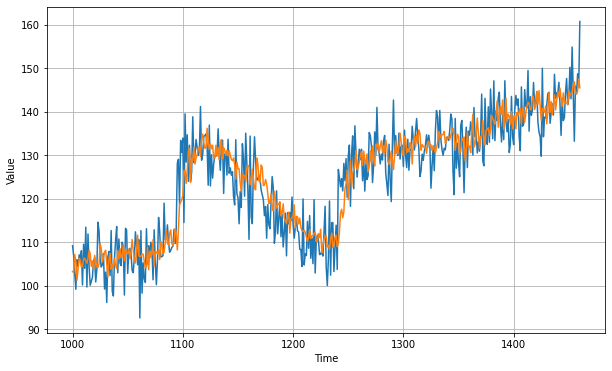

In [33]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [44]:
forecast

array([101.31482697, 102.56756592, 102.58544922, 103.05108643,
       100.82868958, 100.84533691, 103.32409668, 105.98197174,
       104.97034454, 105.90782166, 101.65341187, 102.81570435,
       103.81886292, 106.76478577, 103.53509521, 105.16472626,
       103.57475281, 104.74861145, 101.73703003, 105.32453918,
       102.34217072, 104.5296402 , 102.07478333, 101.57635498,
       105.32077026, 108.32654572, 107.14602661, 105.02336884,
       103.62419128, 103.72312164, 103.86727905, 104.87747192,
       102.14582825, 102.13153076, 103.14640808, 104.91015625,
       104.26860046, 104.90987396,  99.45960236, 101.14373779,
       105.37889099, 106.4597702 , 106.57557678, 103.91703796,
       105.00881195, 105.57582092, 106.23799133, 109.76628876,
       102.56082153, 104.14775085, 106.01513672, 107.94820404,
       107.14348602, 107.43421936, 105.902771  , 105.03213501,
       104.12060547, 103.84947205, 106.64520264, 108.8706665 ,
       106.41333771, 106.24682617, 104.2845459 , 103.48

In [45]:

forecast = range(len(series) - window_size)
forecast = map(lambda x: model.predict(series[x:x + window_size][np.newaxis]), forecast)
forecast = np.fromiter(forecast, dtype=np.float64)

forecast = forecast[split_time-window_size:][:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.702552

In [46]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

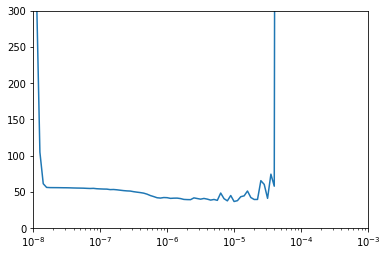

In [47]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [48]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

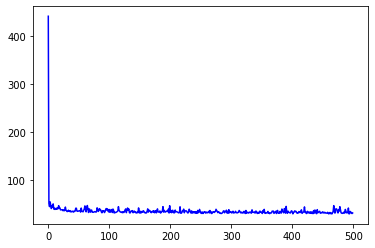

In [49]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[41.6546745300293, 39.02406692504883, 39.81637954711914, 41.65715789794922, 39.32596969604492, 41.925933837890625, 40.505828857421875, 46.902801513671875, 41.83724594116211, 42.39328384399414, 38.089599609375, 38.15385055541992, 38.23164367675781, 38.46095657348633, 36.40464401245117, 38.1304931640625, 36.11333084106445, 37.654212951660156, 43.93782043457031, 37.40834426879883, 35.67225646972656, 34.531185150146484, 35.15626907348633, 37.44226837158203, 35.468894958496094, 34.67733383178711, 36.52190399169922, 33.811092376708984, 34.139129638671875, 35.29579544067383, 35.151824951171875, 33.39152526855469, 35.34811019897461, 34.68973159790039, 35.64023971557617, 41.540138244628906, 41.532615661621094, 35.44810104370117, 35.0738525390625, 35.34459686279297, 35.907779693603516, 36.21002197265625, 36.62793731689453, 33.40605163574219, 41.83472442626953, 35.31095886230469, 34.640926361083984, 34.0898551940918, 36.861045837402344, 39.78098678588867, 46.40639877319336, 40.209903717041016, 33

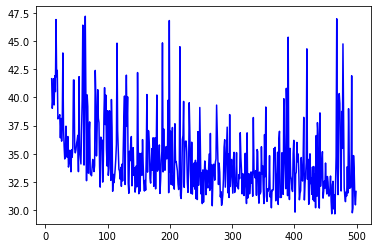

In [50]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

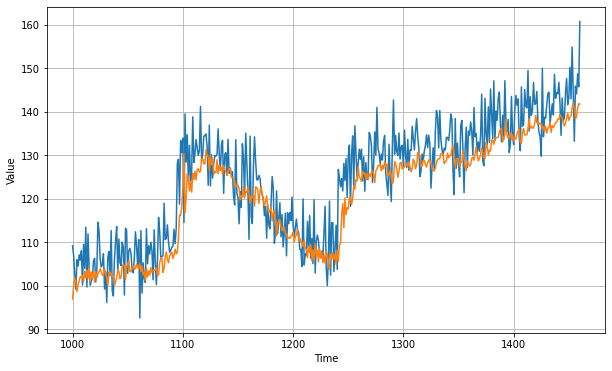

In [51]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [52]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.373631